In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from time import time
from nltk import sent_tokenize

from sklearn.datasets import fetch_lfw_people

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### Applications of facial recognition

In [2]:
lfw_people = fetch_lfw_people(resize=.4, min_faces_per_person=70)

In [5]:
n_sample, height, width = lfw_people.images.shape
n_sample, height, width

(1288, 50, 37)

In [6]:
X = lfw_people.data
y = lfw_people.target

X.shape, y.shape

((1288, 1850), (1288,))

In [7]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6], dtype=int64)

In [11]:
lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [16]:
pd.value_counts(lfw_people.target_names[y])

George W Bush        530
Colin Powell         236
Tony Blair           144
Donald Rumsfeld      121
Gerhard Schroeder    109
Ariel Sharon          77
Hugo Chavez           71
dtype: int64

Text(0.5,1,'Hugo Chavez')

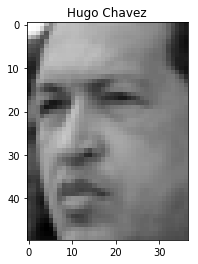

In [13]:
plt.imshow(X[0].reshape((height, width)), cmap=plt.cm.gray)
plt.title(lfw_people.target_names[y[0]])

Text(0.5,1,'Hugo Chavez')

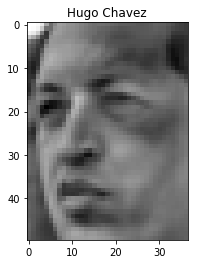

In [15]:
plt.imshow(StandardScaler().fit_transform(X)[0].reshape((height, width)), 
           cmap=plt.cm.gray)
plt.title(lfw_people.target_names[y[0]])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((966, 1850), (322, 1850), (966,), (322,))

In [32]:
pca = PCA(n_components=200, whiten=True)
std = StandardScaler()

preprocessing = Pipeline([
    ('std', std),
    ('pca', pca),
])

preprocessing.fit(X_train)

Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=200, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True))])

In [33]:
extracted_pca = preprocessing.steps[1][1]

Text(0,0.5,'cumulative explained variance')

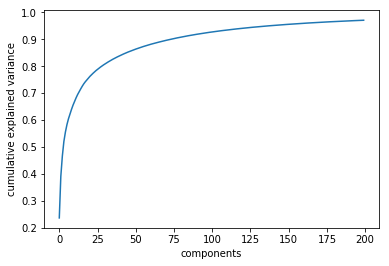

In [34]:
plt.plot(extracted_pca.explained_variance_ratio_.cumsum())
plt.xlabel('components')
plt.ylabel('cumulative explained variance')

Text(0.5,1,'first 16 principal components')

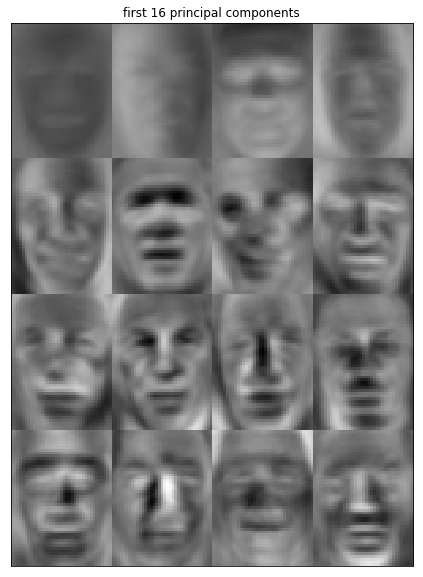

In [35]:
nrows, ncols = 4, 4
display = np.zeros(shape=(nrows*height, ncols*width))

for r in range(nrows):
    for c in range(ncols):
        idx = r*4 + c
        display[r*height:(r+1)*height, c*width:(c+1)*width] = extracted_pca.components_[idx].reshape((height, width))
        

plt.figure(figsize=(10, 10))
plt.imshow(display, cmap=plt.cm.gray)
plt.xticks([])
plt.yticks([])
plt.title("first {} principal components".format(nrows*ncols))

In [36]:
# logistic regression without pca

logreg = GridSearchCV(LogisticRegression(), {'C': [.01, .1, 1, 10, 100]})
logreg.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=0)

In [37]:
logreg.best_score_, logreg.best_params_

(0.8312629399585921, {'C': 0.01})

In [39]:
best_logreg = logreg.best_estimator_

y_pred = best_logreg.predict(X_test)

In [54]:
print("Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))

Test Accuracy: 0.8137


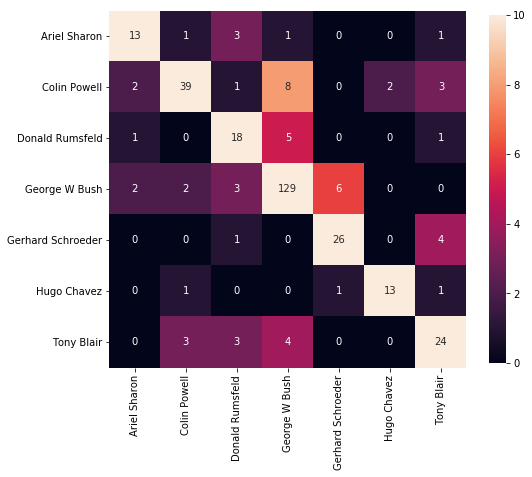

In [55]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), square=True, 
            ax=ax, cbar_kws={'shrink':.8}, fmt='d',
            annot=True, xticklabels=lfw_people.target_names, 
            yticklabels=lfw_people.target_names, 
            vmax=10, vmin=0)

In [57]:
print(classification_report(y_test, y_pred, target_names=lfw_people.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.72      0.68      0.70        19
     Colin Powell       0.85      0.71      0.77        55
  Donald Rumsfeld       0.62      0.72      0.67        25
    George W Bush       0.88      0.91      0.89       142
Gerhard Schroeder       0.79      0.84      0.81        31
      Hugo Chavez       0.87      0.81      0.84        16
       Tony Blair       0.71      0.71      0.71        34

      avg / total       0.82      0.81      0.81       322



Test Accuracy: 0.7298
------------------------------------------------------------
                   precision    recall  f1-score   support

     Ariel Sharon       0.56      0.53      0.54        19
     Colin Powell       0.71      0.64      0.67        55
  Donald Rumsfeld       0.59      0.64      0.62        25
    George W Bush       0.78      0.87      0.82       142
Gerhard Schroeder       0.78      0.68      0.72        31
      Hugo Chavez       0.65      0.69      0.67        16
       Tony Blair       0.70      0.56      0.62        34

      avg / total       0.73      0.73      0.73       322

------------------------------------------------------------
136.5525839328766 seconds to grid search and display result


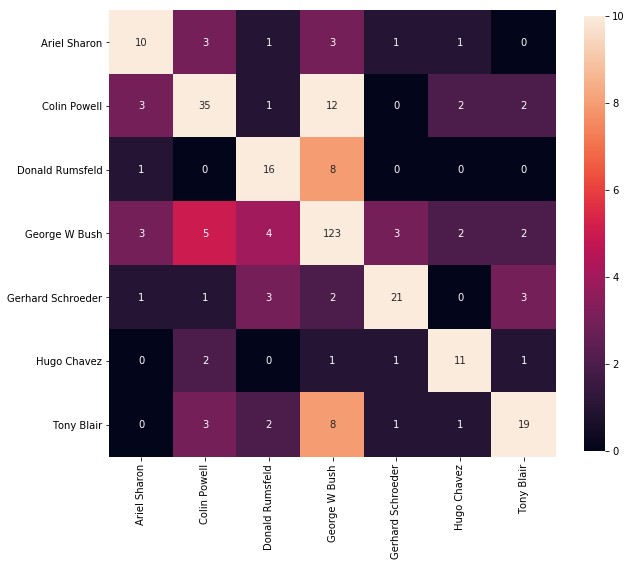

In [60]:
# pca + logistic regression
t0 = time()
face_pipe = Pipeline([
    ('pca', PCA(n_components=200)),
    ('clf', LogisticRegression())
])

face_params = {
    'clf__C': [.01, .1, 1, 10, 100],
}

face_grid = GridSearchCV(face_pipe, face_params)
face_grid.fit(X_train, y_train)

best_clf = face_grid.best_estimator_
y_pred = best_clf.predict(X_test)

print("Test Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print('--'*30)
print(classification_report(y_test, y_pred, target_names=lfw_people.target_names))
print('--'*30)

fig, ax= plt.subplots(figsize=(10, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), square=True, fmt='d', annot=True, ax=ax,
           cbar_kws={'shrink':.8}, xticklabels=lfw_people.target_names, yticklabels=lfw_people.target_names,
           vmin=0, vmax=10)

print("{:.2f} seconds to grid search and display result".format(time()-t0))

In [61]:
face_grid.cv_results_['mean_fit_time']
face_grid.cv_results_['mean_score_time']

array([ 4.47242713,  6.38900431,  8.28965386,  9.8514212 , 10.79708354])

In [65]:
def get_best_model_and_display_results(model, params, X, y, header=''):
    # training
    grid = GridSearchCV(model, params, error_score=0.0)
    grid.fit(X, y)
    
    # display result
    header = header or model.__class__.__name__
    print(header + ':')
    print('-'*len(header))
    print("Best Accuracy: {:.4f}".format(grid.best_score_))
    print("Best params: {}".format(grid.best_params_))
    print("--"*30)
    print('Average Training time[s]: {:.2f}'.format(grid.cv_results_['mean_fit_time'].mean()))
    print("Average Prediction time[s]: {:.2f}".format(grid.cv_results_['mean_score_time'].mean()))
    return grid

In [66]:
preprocessing = Pipeline([
    ('std', StandardScaler()),
    ('pca', PCA()),
    ('lda', LinearDiscriminantAnalysis()),
])

face_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('clf', LogisticRegression()),
])

face_params = {
    'preprocessing__lda__n_components': range(1, 7),
    'preprocessing__pca__n_components': [100, 150, 200, 250],
    'preprocessing__pca__whiten': [True, False],
    'clf__C': [.01, .1, 1, 10, 100],
}

face_grid = get_best_model_and_display_results(face_pipe, face_params, 
                                               X_train, y_train, 
                                               'Std -> PCA -> LDA -> LogReg')

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\L

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\L

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\L

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\L

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\L

C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\Local\Continuum\anaconda3\envs\deep_learning\lib\site-packages\sklearn\discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
C:\Users\LENOVO\AppData\L

Std -> PCA -> LDA -> LogReg:
---------------------------
Best Accuracy: 0.8385
Best params: {'preprocessing__pca__n_components': 250, 'clf__C': 1, 'preprocessing__pca__whiten': True, 'preprocessing__lda__n_components': 6}
------------------------------------------------------------
Average Training time[s]: 0.23
Average Prediction time[s]: 0.02


#### Case study 2 - predicting topics of hotel reviews data

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [69]:
hotel_reviews = pd.read_csv('data/7282_1.csv')

In [70]:
hotel_reviews.head()

,address,categories,city,country,latitude,longitude,name,postalCode,province,reviews.date,reviews.dateAdded,reviews.doRecommend,reviews.id,reviews.rating,reviews.text,reviews.title,reviews.userCity,reviews.username,reviews.userProvince
0,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-09-22T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,4.0,Pleasant 10 min walk along the sea front to th...,Good location away from the crouds,NaN,Russ (kent),NaN
1,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-04-03T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Really lovely hotel. Stayed on the very top fl...,Great hotel with Jacuzzi bath!,NaN,A Traveler,NaN
2,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2014-05-13T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,Ett mycket bra hotell. Det som drog ner betyge...,Lugnt l��ge,NaN,Maud,NaN
3,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2013-10-27T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,Good location on the Lido.,NaN,Julie,NaN
4,Riviera San Nicol 11/a,Hotels,Mableton,US,45.421611,12.376187,Hotel Russo Palace,30126,GA,2015-03-05T00:00:00Z,2016-10-24T00:00:25Z,NaN,NaN,5.0,We stayed here for four nights in October. The...,������ ���������������,NaN,sungchul,NaN


In [71]:
hotel_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35912 entries, 0 to 35911
Data columns (total 19 columns):
address                 35912 non-null object
categories              35912 non-null object
city                    35912 non-null object
country                 35912 non-null object
latitude                35826 non-null float64
longitude               35826 non-null float64
name                    35912 non-null object
postalCode              35857 non-null object
province                35912 non-null object
reviews.date            35653 non-null object
reviews.dateAdded       35912 non-null object
reviews.doRecommend     0 non-null float64
reviews.id              0 non-null float64
reviews.rating          35050 non-null float64
reviews.text            35890 non-null object
reviews.title           34290 non-null object
reviews.userCity        16263 non-null object
reviews.username        35869 non-null object
reviews.userProvince    17518 non-null object
dtypes: float64(5), 

In [72]:
hotel_reviews.nunique()

address                   999
categories                396
city                      761
country                     1
latitude                  982
longitude                 983
name                      879
postalCode                911
province                  287
reviews.date             3009
reviews.dateAdded        1029
reviews.doRecommend         0
reviews.id                  0
reviews.rating             43
reviews.text            34397
reviews.title           21961
reviews.userCity         2897
reviews.username        15492
reviews.userProvince      648
dtype: int64

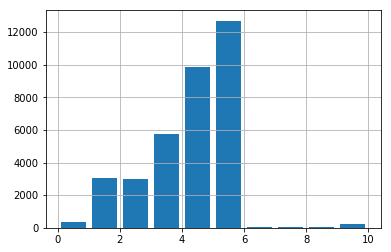

In [82]:
hotel_reviews['reviews.rating'].hist(bins=np.linspace(0, 10, num=11), rwidth=.8)

In [84]:
pd.value_counts(hotel_reviews['name']).head(15)

The Alexandrian, Autograph Collection           1185
Howard Johnson Inn - Newburgh                    714
Americas Best Value Inn                          567
Fiesta Inn and Suites                            546
Ip Casino Resort Spa                             392
Best Western Plus Waterville Grand Hotel         335
Hampton Inn Virginia Beach Oceanfront North      334
Comfort Suites                                   326
New York Marriott Marquis                        320
Best Western of Long Beach                       317
Plaza Hotel and Casino - Las Vegas               289
Doubletree By Hilton West Palm Beach Airport     276
Anaheim Marriott Suites                          275
Jacksonville Plaza Hotel and Suites              264
Red Roof Inn Erie                                243
Name: name, dtype: int64

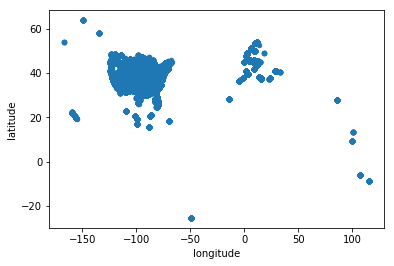

In [85]:
hotel_reviews.plot.scatter(x='longitude', y='latitude')

In [89]:
# filter only US hotel
hotel_reviews = hotel_reviews.query('(-122 <= longitude <= -65) & (24 <= latitude <= 50)')

In [90]:
hotel_reviews.shape

(30692, 19)

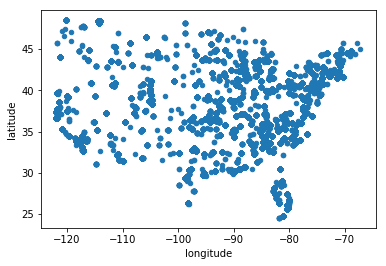

In [91]:
hotel_reviews.plot.scatter(x='longitude', y='latitude')

In [94]:
hotel_reviews.columns = hotel_reviews.columns.str.replace('.', '_')
hotel_reviews.columns

Index(['address', 'categories', 'city', 'country', 'latitude', 'longitude',
       'name', 'postalCode', 'province', 'reviews_date', 'reviews_dateAdded',
       'reviews_doRecommend', 'reviews_id', 'reviews_rating', 'reviews_text',
       'reviews_title', 'reviews_userCity', 'reviews_username',
       'reviews_userProvince'],
      dtype='object')

In [95]:
texts = hotel_reviews['reviews_text']

In [114]:
def tokenize(x):
    try:
        return sent_tokenize(x)
    except TypeError:
        return []

In [123]:
sentences = sum((review for review in texts.map(tokenize)), [])

In [124]:
len(sentences)

118135

In [125]:
sentences[:5]

['to share your opinion of this businesswith YP visitors across the United Statesand in your neighborhood',
 'to share your opinion of this businesswith YP visitors across the United Statesand in your neighborhood',
 'to share your opinion of this businesswith YP visitors across the United Statesand in your neighborhood',
 'We had a wonderful, relaxing time.',
 'The staff were completely attentive and accommodating.']

In [127]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))

In [128]:
sentence_tfidf = tfidf.fit_transform(sentences)

In [129]:
sentence_tfidf

<118135x280901 sparse matrix of type '<class 'numpy.float64'>'
	with 1180257 stored elements in Compressed Sparse Row format>

In [143]:
svd = TruncatedSVD(n_components=1000)
svd.fit(sentence_tfidf)

TruncatedSVD(algorithm='randomized', n_components=1000, n_iter=5,
       random_state=None, tol=0.0)

Text(0.5,1,'Tfidf + SVD')

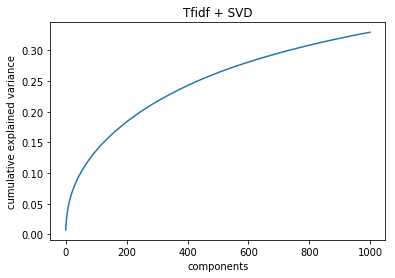

In [144]:
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('components')
plt.ylabel('cumulative explained variance')
plt.title('Tfidf + SVD')

In [134]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [133]:
iris = load_iris()

X_iris = iris.data
X_iris.shape

(150, 4)

In [135]:
X_centered = StandardScaler(with_std=False).fit_transform(X_iris)
X_scaled = StandardScaler().fit_transform(X_iris)

In [137]:
pca = PCA(n_components=2)
svd = TruncatedSVD(n_components=2)

In [140]:
# Raw data: check if pca components == svd components
(pca.fit(X_iris).components_ - svd.fit(X_iris).components_).mean()

0.13018312309437863

In [141]:
# Centered data: if pca == svd components
(pca.fit(X_centered).components_ - svd.fit(X_centered).components_).mean()

8.326672684688674e-17

In [142]:
# Scaled data: if pca == svd components
(pca.fit(X_scaled).components_ - svd.fit(X_scaled).components_).mean()

1.5872719805187785e-16